<a href="https://colab.research.google.com/github/uyan21/deepLearningStudy/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#tensorflow 사이트에 있는 코드 분석
https://www.tensorflow.org/tutorials/generative/dcgan
#생성적 적대 신경망(번역명이 좀 이상해서 문자그대로 생각하면 어려움) 
#(Generative Adversarial Networks)
#컴퓨터가 그림이나 글씨체를 학습해서 그럴싸하게 따라 그리거나 글씨를 쓰는 것 그거임
#쉽게 설명하면 두가지 레이어모델이 등장하는데 하나는 제너레이터(생성자)고
#하나는 디스크리미네이터(검증자)이다.
#제너레이터가 자기 마음대로 지폐를 찍어내는 위조지폐범이면
#디스크리미네이터는 이게 위조지폐인지 진짜인지 판별하게 하는 것
#적대라는 뜻은 한명은 위조지폐 찍어내고 한명은 진짜와 비교해 보고 
#검증 판별을 학습시켜서
#위조지폐범은 검증자에게 검사받아보고 퇴짜 맞으면서 계속 학습을 하다보면 
#결국 더 그럴싸하고 진짜와 흡사한 위조지폐를 만들게 된다는 원리

#예)존재 하지 않는 사람 얼굴 생성기도 이 원리로 만드는 모델임



#이러한 라이브러리가 필요하다

In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

mnist 데이터 다운 받아서 정규화 한다

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화합니다.
BUFFER_SIZE = 60000
BATCH_SIZE = 256

batch란 한번에 집어넣는 내용 
(예 batch_size가 256이면 256문제를 풀고 답을 맞춰서 복습을 하는것)

In [3]:
# 데이터 배치를 만들고 섞습니다.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#요약
생성자 모델<br>
랜덤으로 28x28 픽셀 그림 그려서 만들어 내는거임<br>
인풋이 왜 100이냐면 그냥 난수 시드라고 생각 하면 됨<br>
랜덤시드(100)->[make_generrator_model()]->28x28 픽셀 그림

In [4]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

아까 말했다시피 생성자 모델이 시드 받아서 이 레이어 모델이 그린거임<br>
아무런 학습이 되어있지 않아서 막 그린다.

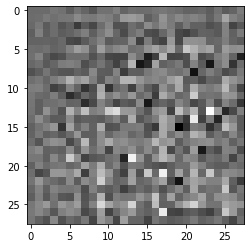

In [5]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

make_discriminator_model<br>
함수형으로 구현된 검증 모델<br>
28x28 픽셀 그림을 집어넣고 <br>
진짜 글씨쓴거라고 생각되면 양수 <br>
저 위에 애가 만들었다 싶으면 음수<br> 출력하게 만듦

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

아까 저위에 만들어논 위조 이미지 검증자로 검증해보니 0.001~이렇게 나옴<br>
아직 학습이 되지 않아서 별 의미는 없다

In [7]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00186639]], shape=(1, 1), dtype=float32)


손실 함수 할당<br>
손실률 계산 함수<br>
binary_cross_entropy 함수 공식<br>
쉽게 말하면 두 파라미터가 서로 얼마나 떨어져 있나를 계산하는 함수다
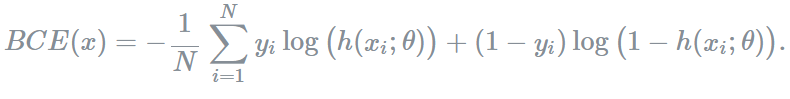

In [8]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

쉽게 설명하면 두 배열이 얼마나 멀리 떨어져 있나를 계산한다<br><br>
[0]으로 구성된 1x1 배열과<br>
[?] 0~9까지 1x1 배열을 비교하여 엔트로피 값을 출력 해봄<br><br>
값차이가 날수록 커진다는걸 알수 있다<br><br>
0 0 비교했는데 왜 0.6931472 이렇게 나왔냐 생각할 수도 있는데<br>
그냥 기본 계수값이라 생각하면 됨

In [9]:
for i in range(0,10):
  test=cross_entropy([0.],[float(i)])
  print(test.numpy())

0.6931472
1.3132617
2.126928
3.0485873
4.01815
5.0067153
6.0024757
7.000911
8.000336
9.000123


위에 엔트로피 함수를 이용하여 매소드를 정의한다
이거는 진짜 이미지랑 1로 구성된 28x28 배열과<br>
위조 이미지랑 0으로 구성된 28x28 배열의 엔트로피를 계산하여<br>
합쳐서 출력하는 함수를 정의함
<br>
쉽게 말하면 검증자가 위조지폐 얼마나 검증 못 했는지 검사하는
값 <br>계산하는 함수라고 보면됨


In [10]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

이거는 생성자 모델 입장에서 위조이미지를 얼마나 들켯는지 값

In [11]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

레이어 모델이 두개이므로 두개 각각 옵티마이저를 설정해준다

In [12]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

200회 반복<br>
아까 100x1사이즈를 생성자 모델 인풋 디멘션으로 줬으니 100으로 설정한거고<br>
16은 16개를 넣는다는 것<br>
100 짜리 크기의 시드가 16개씩 생성자 모델에 들어간다는 뜻이다<br>
100x1을 16개 연속으로 시드로 집어 넣기 위해 이렇게 설정함 

In [13]:
EPOCHS = 200
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
seed = tf.random.normal([num_examples_to_generate, noise_dim])

여기서 부터는 간단하게 설명하기 어려워서 코드별로 주석을 단다.<br>
존대말은 개발자 주석이고 반말은 내 주석임

In [14]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.
@tf.function
#훈련(학습) 함수 정의 해놈
def train_step(images):
    #100x1 짜리가 256개인 시드를 준다
    #위에 16개 짜리는 개발자가 편하게 쓸려고 따로 받은건데 별 의미 없음
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    #학습자(레이어모델)이 둘이므로 GradientTape 두개 열어놓고 학습함 
    #피드 백 2번 해야함으로
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      #생성자가 이미지 만들어낸다
      generated_images = generator(noise, training=True)
      #이제 검증자가 진짜랑 가짜 판별값을 real,fake 변수에 담는다
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)
      #각각 위에 정의했던 함수로 엔트로피 값 구함

      #gen은 위조 이미지를 얼마나 들켰는지의 값이고
      #disc는 진짜와 가짜를 얼마나 못 구분했는지의 값이라 보면됨 
      #얘네들 각자 이 손실 수치를 포함하여 피드백 한다
      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)
    #GradientTape 닫고 각각 피드백 시작한다
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    #각각 최적화 함수로 최적화 시키는것임
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

#복잡하게시리 전체적으로 학습시킬 함수를 또 정의해 놈

In [15]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)


    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

#이거는 그냥 개발자가 배열 이미지로 만들어서 시각화 하려고 만듦

In [16]:
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

#훈련시작
epoch가 돌 때마다 이미지를 출력하게 코딩해놈

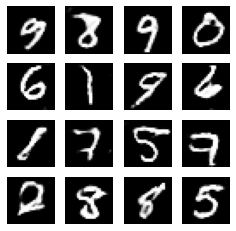

CPU times: user 8min 9s, sys: 1min 30s, total: 9min 40s
Wall time: 35min 38s


In [17]:
%%time
train(train_dataset, EPOCHS)

In [18]:
# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

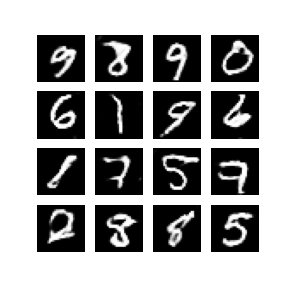

In [19]:
display_image(EPOCHS)

밑으로는 개발자가 파일로 만들려고 쓴코드

In [22]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

In [23]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

이러한 방식을 
(Deep Convolutional Generative Adversarial Networks, DCGAN)
<br>이라고하는데<br>
tensorflow 사이트에 코드가 제공되며<br>
예제가 학습시간도 길지않아서 부담 안된다<br>
하지만 코드 내용 자체와 GAN방식이 복잡하고 상당히 어렵기 때문에<br>
이해하고 써먹는데 까지 시간투자를 많이 해야한다<br>
여기서 소개된 GAN방식은 28x28 픽셀단위에서 학습했기 때문에<br>
시간이 오래걸리지 않았지만<br>
고해상도를 취급할때는 꽤나 많은 시간과 컴퓨팅 자원을 필요로 한다<br>
너무 어렵기 때문에 이해 못해도 컴퓨터 실력 안 좋은 것 아님
